# Predicting the Next Token in an Occasionally Dishonest Casino

This is inspired by [this tutorial](https://probml.github.io/dynamax/notebooks/hmm/casino_hmm_inference.html) from the dynamax package, which shows how to use a [Hidden Markov Model (HMM)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to infer the next die roll in an "occasionally dishonest casino". The set up is described below. The idea of this notebook is to train an RNN to perform this task and show that it approximates the predictions of an optimal Bayesian observer. I think this is cool, because it is a concrete demonstration of RNNs performing optimal Bayesian inference and I would like to understand how they accomplish this.

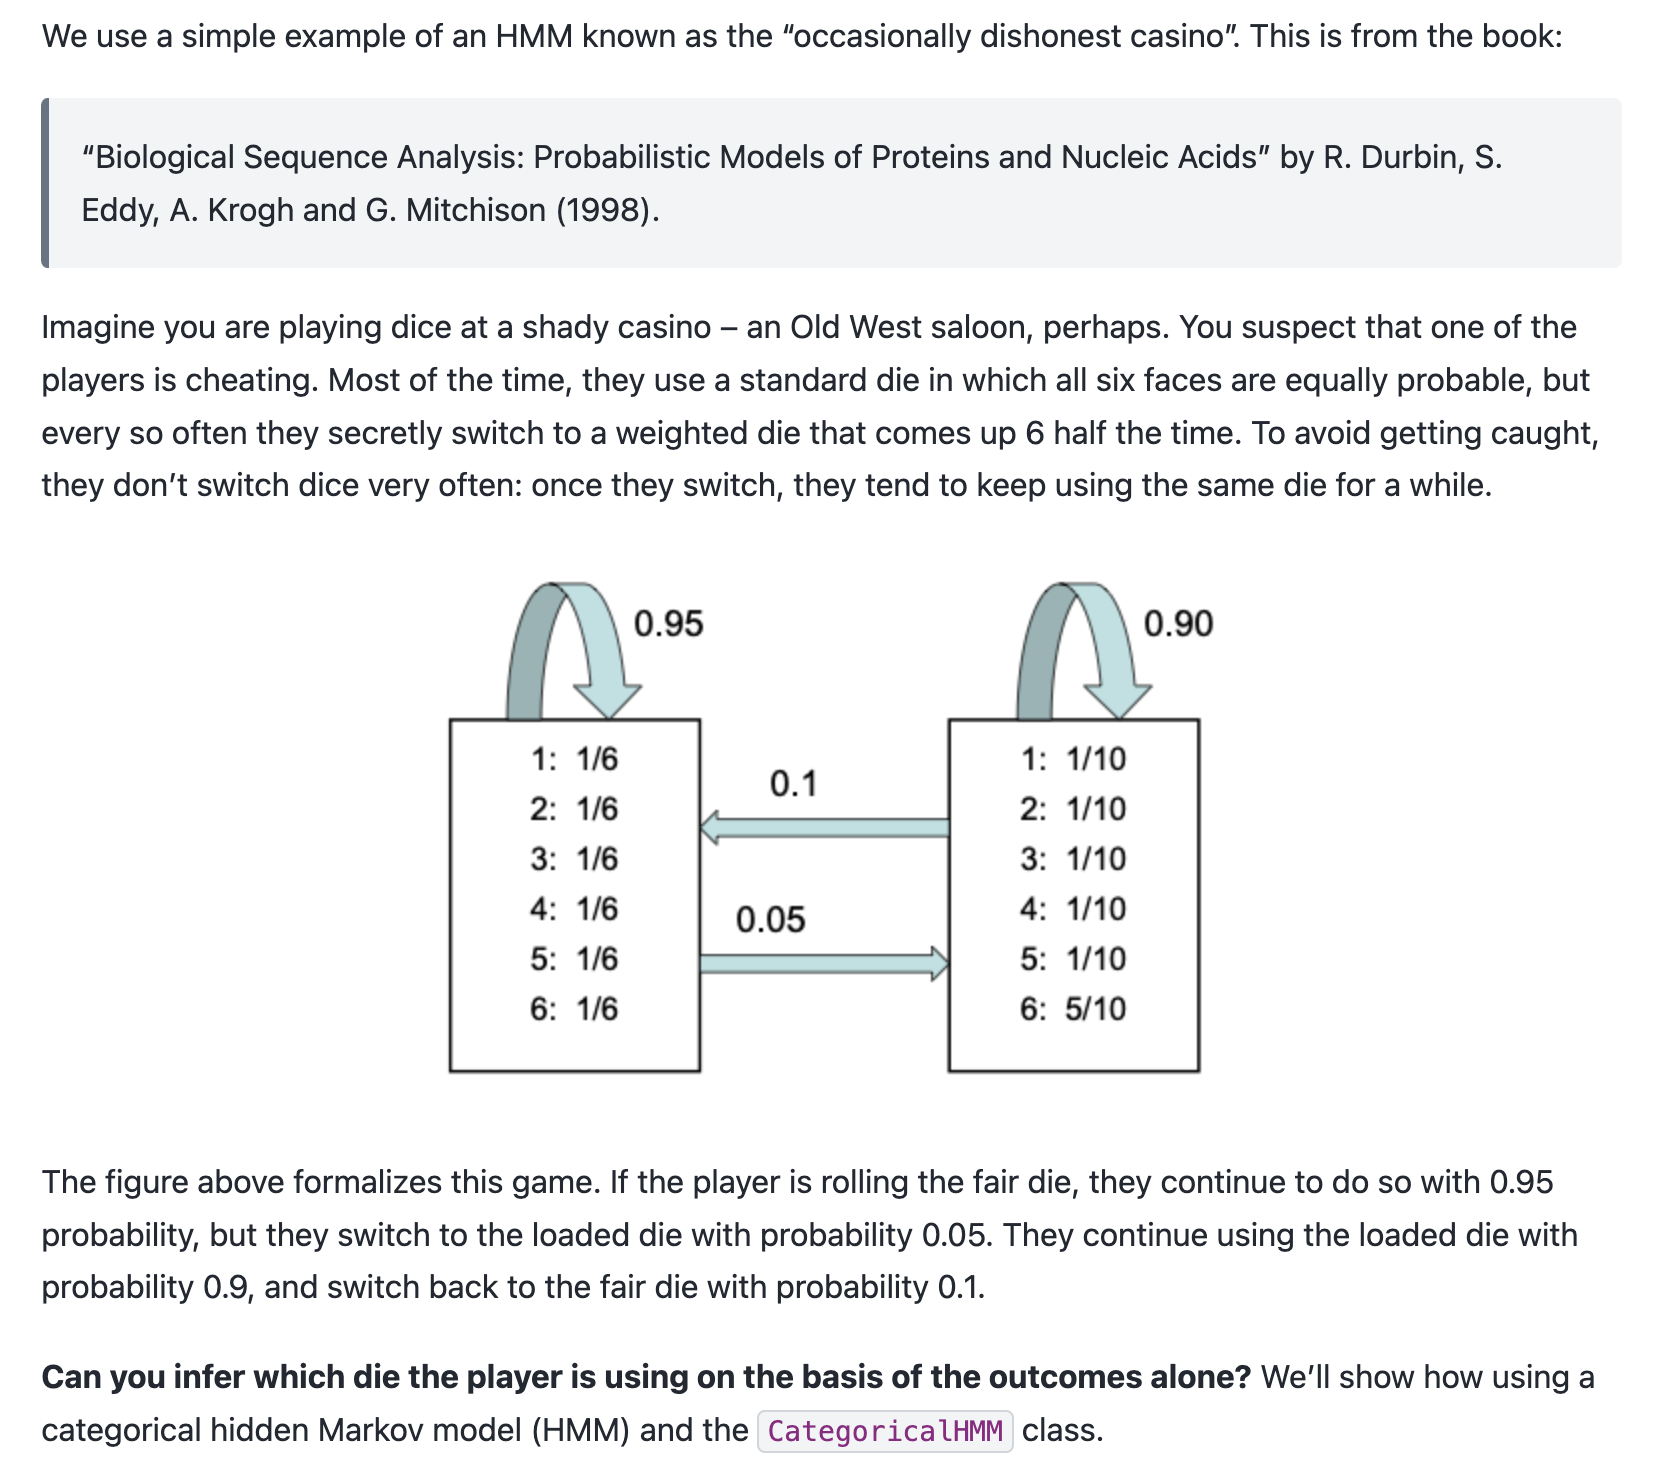


In [10]:
!pip install dynamax
import dynamax

/Users/atanelus/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import jax
from jax import vmap
from jax.nn import one_hot

from flax import nnx
import optax

from tqdm import trange

from dynamax.hidden_markov_model import CategoricalHMM

In [ ]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.95, 0.05], [0.05, 0.95]])
emission_probs = jnp.array(
    [
        [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
        [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],
    ]
)  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: (2, 2)
B.shape: (2, 6)


In [ ]:
num_states = 2  # two types of dice (fair and loaded)
num_emissions = 1  # only one die is rolled at a time
num_classes = 6  # each die has six faces

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
hmm_params, _ = hmm.initialize(
    initial_probs=initial_probs,
    transition_matrix=transition_matrix,
    emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes),
)

In [14]:
num_timesteps = 512
true_states, emissions = hmm.sample(hmm_params, jr.PRNGKey(42), num_timesteps)

Text(0.5, 1.0, 'sampled sequence (white=fair, gray=loaded)')

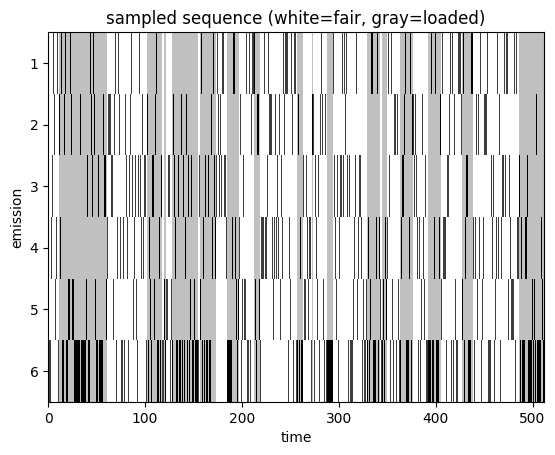

In [ ]:
plt.imshow(
    one_hot(emissions[:, 0], 6).T, aspect="auto", interpolation="none", cmap="Greys"
)
plt.imshow(
    true_states[None, :],
    extent=(0, num_timesteps, num_classes - 0.5, -0.5),
    interpolation="none",
    aspect="auto",
    cmap="Greys",
    alpha=0.25,
)
plt.xlabel("time")
plt.ylabel("emission")
plt.yticks(jnp.arange(6), jnp.arange(6) + 1)  # b/c python is zero indexed!
plt.title("sampled sequence (white=fair, gray=loaded)")

In [16]:
posterior = hmm.filter(hmm_params, emissions)
print(f"marginal likelihood: {posterior.marginal_loglik: .2f}")
print(f"posterior.filtered_probs.shape: {posterior.filtered_probs.shape}")

marginal likelihood: -869.60
posterior.filtered_probs.shape: (512, 2)


Text(0.5, 1.0, 'Filtering Distribution')

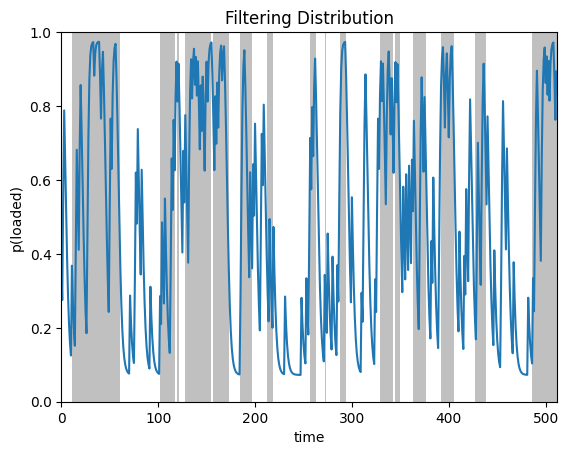

In [17]:
plt.imshow(
    true_states[None, :],
    extent=(0, num_timesteps, 0, 1),
    interpolation="none",
    aspect="auto",
    cmap="Greys",
    alpha=0.25,
)
plt.plot(posterior.filtered_probs[:, 1])  # probability of the loaded state (z=1)
plt.xlabel("time")
plt.ylabel("p(loaded)")
plt.ylim(0, 1)
plt.title("Filtering Distribution")

In [18]:
# == Define Model == #

# This is a model with a multiple linear RNNs stack on top of each other
# with nonlinear multi-layer perceptrons connecting them.

# Inspired by: https://arxiv.org/abs/2303.06349

from flax.nnx.nn.recurrent import SimpleCell, RNN
from flax.nnx import Sequential, Linear, gelu


class ResidualLayer(nnx.Module):
    def __init__(self, dimension: int, *, residual=True, rngs: nnx.Rngs):
        self.linear1 = Linear(dimension, dimension, rngs=rngs)
        self.bn = nnx.BatchNorm(dimension, rngs=rngs)
        self.residual = residual

    def __call__(self, x: jax.Array):
        return gelu(self.bn(self.linear1(x))) + x


class LRUBlock(nnx.Module):
    def __init__(self, dim_in, dim_out, num_layers, *, rngs: nnx.Rngs):
        self.linear_in = Linear(dim_in, dim_out, rngs=rngs)
        self.cell = SimpleCell(
            in_features=dim_in,
            hidden_features=dim_out,
            rngs=rngs,
            activation_fn=(lambda x: x),
        )
        self.rnn = RNN(self.cell, rngs=rngs)
        self.mlp_layers = [ResidualLayer(dim_out, rngs=rngs) for _ in range(num_layers)]
        self.mlp = Sequential(*self.mlp_layers)

    def __call__(self, x):
        return self.mlp(self.rnn(x))


class LRUModel(nnx.Module):
    def __init__(
        self,
        dim_in: int,
        dim_hidden: int,
        dim_out: int,
        mlp_depth: int,
        num_layers: int,
        *,
        rngs: nnx.Rngs,
    ):
        self.lru_blocks = [
            LRUBlock(dim_in=dim_in, dim_out=dim_hidden, num_layers=mlp_depth, rngs=rngs)
        ] + (num_layers - 1) * [
            LRUBlock(
                dim_in=dim_hidden, dim_out=dim_hidden, num_layers=mlp_depth, rngs=rngs
            )
        ]
        self.lrus = Sequential(*self.lru_blocks)
        self.readout_layer = Linear(dim_hidden, dim_out, rngs=rngs)

    def __call__(self, x):
        return self.readout_layer(self.lrus(x))

In [19]:
# == Create Model == #
model = LRUModel(
    dim_in=6, dim_hidden=64, dim_out=6, mlp_depth=3, num_layers=3, rngs=nnx.Rngs(0)
)

# == Create Optimizer == #
learning_rate = 0.005
momentum = 0.9
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

In [20]:
# == Method to Sample Training/Test Data == #
def sample_emissions(sample_func, seed, batch_size, num_timesteps):
    """Sample a batch of data."""
    keys = jr.split(jr.PRNGKey(seed), num=batch_size)
    return sample_func(keys, num_timesteps)[1][:, :, 0]


# == Method to Train/Update Model Parameters == #
@nnx.jit
def train_step(model, optimizer, emissions):
    """Train for a single step."""

    # Create loss function for model `m` and emissions `e`
    def loss_fn(m, e):
        return optax.softmax_cross_entropy_with_integer_labels(
            logits=m(one_hot(e[:, :-1], 6)), labels=e[:, 1:]
        ).mean()

    # Use jax to compute the gradient of the parameters
    grad_fn = nnx.value_and_grad(loss_fn)

    # Evaluate the loss and gradients.
    loss, grads = grad_fn(model, emissions)

    # Update parameters, return loss
    optimizer.update(grads)
    return loss

In [ ]:
# == Train Model == #
emissions = []
loss_history = []
num_iterations = 1000
num_train_samples = 5000
num_test_samples = 100
num_timesteps = 512
batch_size = 32

train_states, train_emissions = jax.vmap(hmm.sample, in_axes=[None, 0, None])(
    hmm_params, jr.split(jr.PRNGKey(0), num_train_samples), num_timesteps
)
train_emissions = train_emissions[:, :, 0]

test_states, test_emissions = jax.vmap(hmm.sample, in_axes=[None, 0, None])(
    hmm_params, jr.split(jr.PRNGKey(1), num_test_samples), num_timesteps
)
test_emissions = test_emissions[:, :, 0]

(5000, 512, 1)


In [22]:
for i in trange(num_iterations):
    idx = jr.randint(
        jr.PRNGKey(i), shape=(batch_size,), minval=0, maxval=train_emissions.shape[0]
    )
    loss_history.append(train_step(model, optimizer, train_emissions[idx]))

100%|██████████| 1000/1000 [01:42<00:00,  9.77it/s]


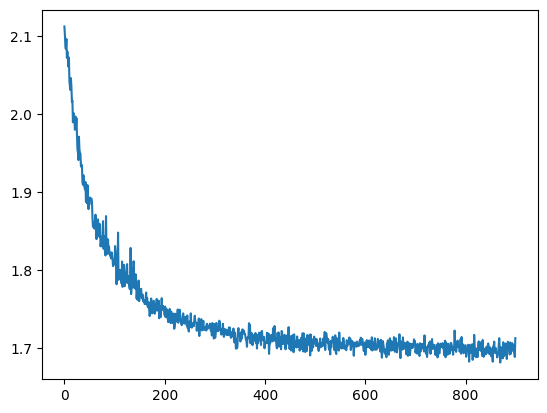

In [23]:
plt.plot(loss_history[100:])

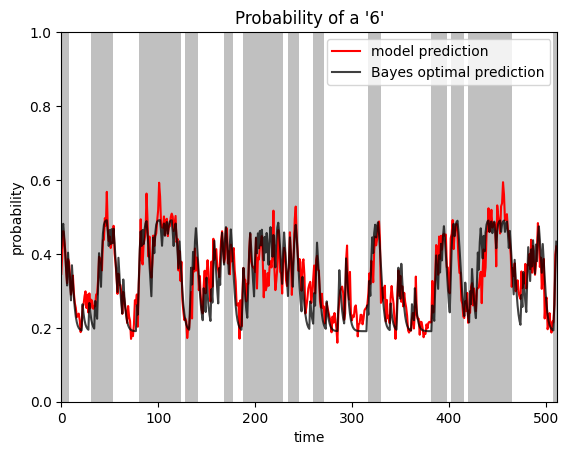

In [24]:
trial = 1
posterior = hmm.filter(hmm_params, test_emissions[trial])
plt.imshow(
    test_states[trial][None, :],
    extent=(0, num_timesteps, 0, 1),
    interpolation="none",
    aspect="auto",
    cmap="Greys",
    alpha=0.25,
)
plt.plot(
    jax.nn.softmax(model(one_hot(test_emissions[trial], 6)), axis=-1)[:, -1],
    label="model prediction",
    color="red",
)
plt.plot(
    posterior.filtered_probs @ hmm_params.emissions.probs[:, 0, -1],
    label="Bayes optimal prediction",
    color="black",
    alpha=0.75,
)
plt.ylabel("probability")
plt.xlabel("time")
plt.title("Probability of a '6'")
plt.legend()